# <center> <u> ANN Trial

In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [109]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, InputLayer, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [103]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [129]:
query="""
    select * 
    from agg.tidy_data
    where site = 64
"""

In [195]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_5411/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [147]:
df.head()

,timestamp,site,year,month,day,hour,min,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,weekend_or_bank_holiday,q25_net_load,q75_net_load,median_net_load
0,2019-06-01 03:15:00+00:00,64,2019,6,1,4,15,5,3,10.23,...,1.0,144,6.0,0.0,0.0,69.89,1,7.2925,53.9725,9.390
1,2019-06-01 03:30:00+00:00,64,2019,6,1,4,30,5,3,8.03,...,1.0,144,6.0,0.0,0.0,63.14,1,7.2100,44.3850,8.500
2,2019-06-01 03:45:00+00:00,64,2019,6,1,4,45,5,3,7.37,...,1.0,144,6.0,0.0,0.0,60.99,1,7.2725,55.3375,8.355
3,2019-06-01 04:00:00+00:00,64,2019,6,1,5,0,5,3,6.87,...,4.0,141,7.0,8.0,0.0,72.09,1,7.1450,54.3750,8.510
4,2019-06-01 04:15:00+00:00,64,2019,6,1,5,15,5,3,6.82,...,4.0,141,7.0,8.0,0.0,73.92,1,6.9925,56.1925,8.435


In [148]:
df.isnull().sum()

timestamp                       0
site                            0
year                            0
month                           0
day                             0
hour                            0
min                             0
day_of_week                     0
season                          0
net_load                        0
precipitation                3264
precipitation_probability    3264
wind_direction               3264
wind_speed                   3264
solar_radiation              3264
sunshine_duration            3264
avg_net_load                    0
weekend_or_bank_holiday         0
q25_net_load                    0
q75_net_load                    0
median_net_load                 0
dtype: int64

In [196]:
df = df[['timestamp','month','day_of_week','season','net_load',
               'avg_net_load','weekend_or_bank_holiday']]

In [197]:
df.rename(columns={'timestamp':'ts'},inplace=True)
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)
df

,month,day_of_week,season,net_load,avg_net_load,weekend_or_bank_holiday
ts,,,,,,
2019-05-09 22:15:00+00:00,5,3,2,7.52,39.13,0
2019-05-09 22:30:00+00:00,5,3,2,7.17,33.41,0
2019-05-09 22:45:00+00:00,5,3,2,7.40,35.10,0
2019-05-09 23:00:00+00:00,5,3,2,9.41,32.95,0
2019-05-09 23:15:00+00:00,5,3,2,7.33,39.84,0
...,...,...,...,...,...,...
2019-05-08 08:15:00+00:00,5,2,2,6.41,-6.24,0
2019-05-08 08:30:00+00:00,5,2,2,7.29,-1.36,0
2019-05-08 08:45:00+00:00,5,2,2,8.58,-5.52,0


In [198]:
df = df.sort_index()

<Axes: xlabel='ts'>

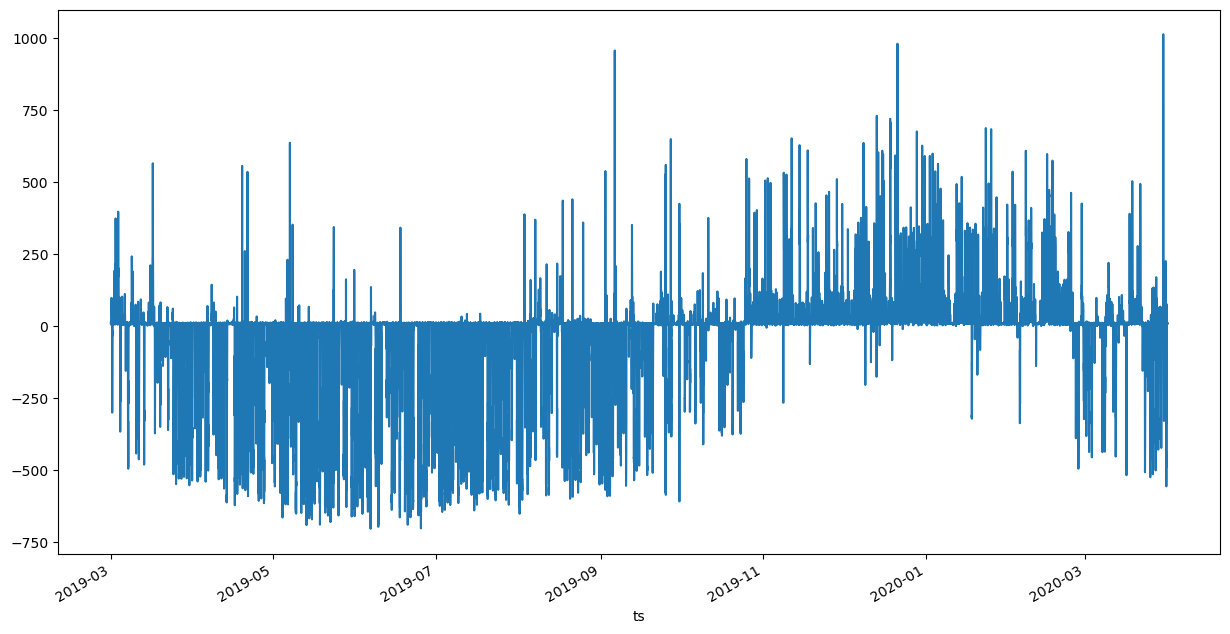

In [199]:
plt.figure(figsize=(15,8))
df['net_load'].plot()

In [200]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df.drop('net_load',axis=1,inplace=True)

## ANN - Without Exogenous Variables

In [201]:
df_simple = df[['net_load_norm']]

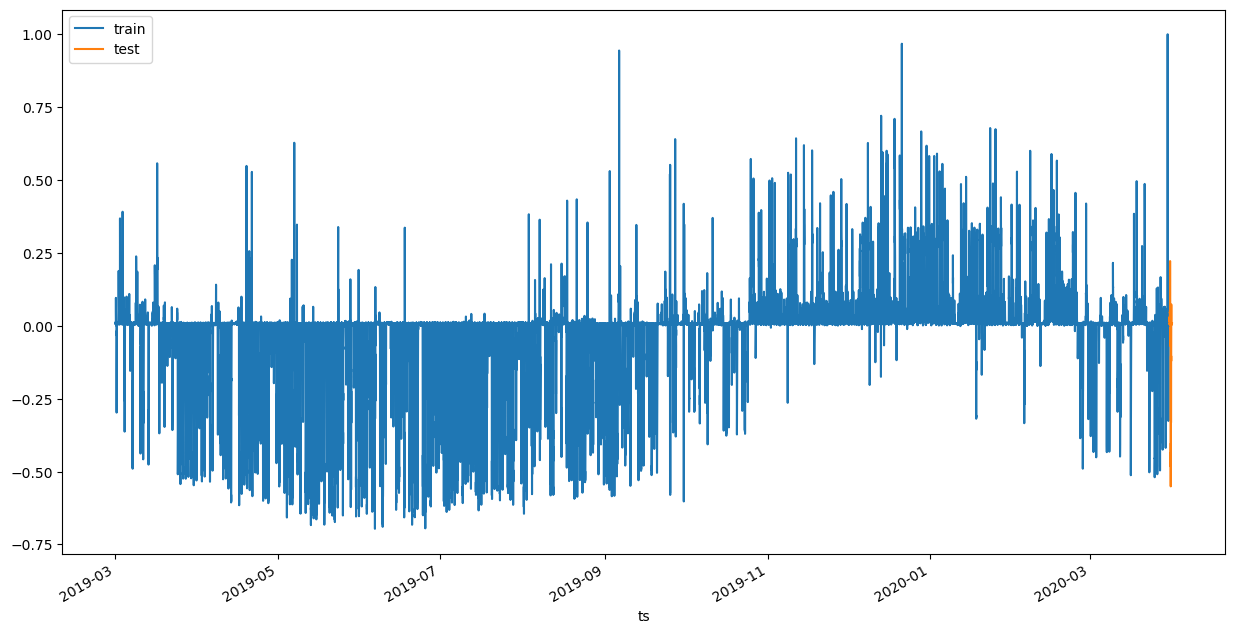

In [204]:
split_date = pd.Timestamp('2020-03-30 23:00:00+00:00', tz='UTC')
df1 = df_simple['net_load_norm']
train = df1.loc[:split_date]
test = df1.loc[split_date:]
plt.figure(figsize=(15,8))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [205]:
print("We have", len(train), "train values")
print("We have", len(test), "test values")

We have 37959 train values
We have 96 test values


In [215]:
train_processed = df_simple.iloc[:, 0:1].values
train_processed = train_processed[26880:37959:1]
test_processed = df_simple.iloc[:, 0:1].values
test_processed = test_processed[37958:38055:1]

In [226]:
X_train = train_processed
y_train = train_processed

In [227]:
X_test = test_processed
y_test = test_processed

In [228]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/10
11079/11079 [==============================] - 4s 340us/step - loss: 2.0610e-04
Epoch 2/10
11079/11079 [==============================] - 4s 325us/step - loss: 2.6849e-05
Epoch 3/10
11079/11079 [==============================] - 4s 337us/step - loss: 1.5892e-05
Epoch 4/10
11079/11079 [==============================] - 4s 335us/step - loss: 6.4366e-06
Epoch 5/10
11079/11079 [==============================] - 4s 326us/step - loss: 1.3138e-05
Epoch 6/10
11079/11079 [==============================] - 4s 344us/step - loss: 4.6169e-06
Epoch 7/10
11079/11079 [==============================] - 4s 328us/step - loss: 7.8297e-06
Epoch 8/10
11079/11079 [==============================] - 4s 336us/step - loss: 9.1712e-06
Epoch 8: early stopping


In [229]:
from sklearn.metrics import r2_score
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

347/347 [==============================] - 0s 296us/step
The R2 score on the Train set is:	0.998
The R2 score on the Test set is:	0.999


In [230]:
nn_y_pred_test = nn_model.predict(X_test)

3/3 [==============================] - 0s 981us/step


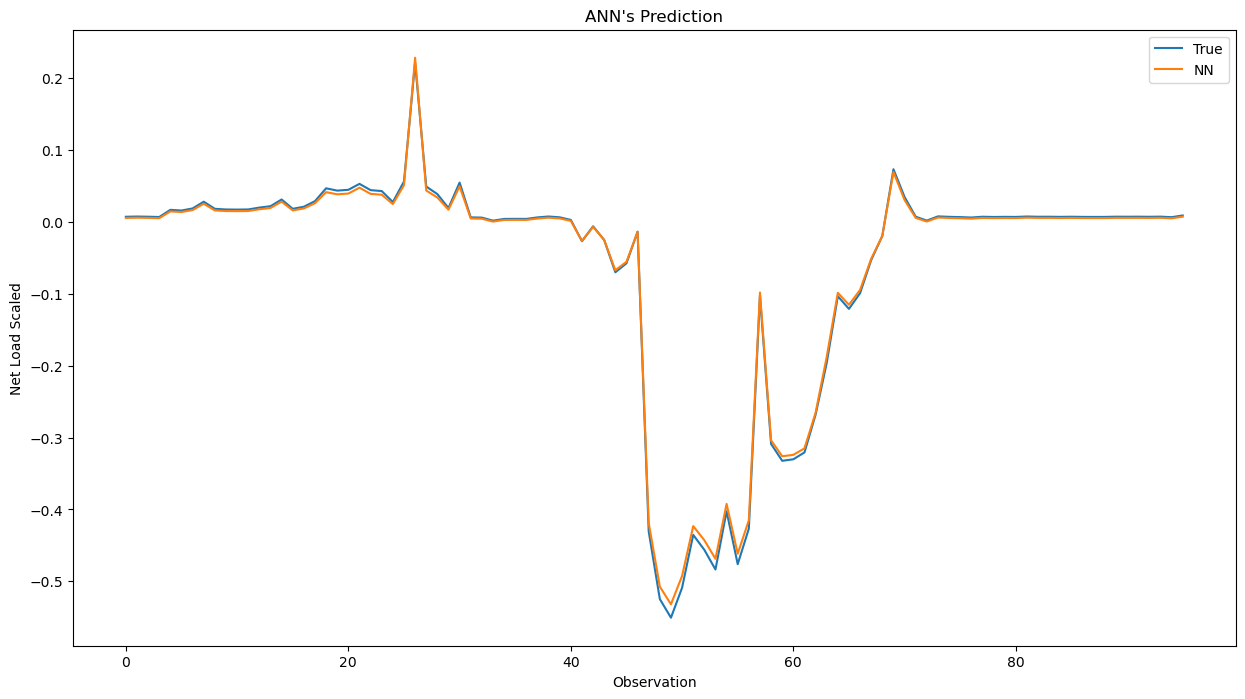

In [232]:
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Net Load Scaled')
plt.legend()
plt.show();

#### Explanation for ANN below:
We make a split date for the last date and make that the test set.

In [261]:
split_date = pd.Timestamp('2020-03-30 23:00:00+00:00', tz='UTC')

df1 = df_simple['net_load_norm']

train = df1.loc[:split_date]
test = df1.loc[split_date:]

In [263]:
print(f"Number of Timestamps for Training Dataset: {len(train)}")
print(f"Number of Timestamps for Training Dataset: {len(test)}")

Number of Timestamps for Training Dataset: 37959
Number of Timestamps for Training Dataset: 96


In [264]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 96  # Number of time steps to look back
X_train, y_train = create_sequences(train.values, seq_length)
X_test, y_test = create_sequences(test.values, seq_length)

In [267]:
seq_length = 96  # Number of time steps to look back

# Check the shape of train and test data
print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

# Check the length of train and test data
print("Length of train data:", len(train))
print("Length of test data:", len(test))

# Check the length of train and test sequences
X_train, y_train = create_sequences(train.values, seq_length)
X_test, y_test = create_sequences(test.values, seq_length)

print("Length of train sequences:", len(X_train))
print("Length of test sequences:", len(X_test))

Shape of train data: (37959,)
Shape of test data: (96,)
Length of train data: 37959
Length of test data: 96
Length of train sequences: 37863
Length of test sequences: 0


In [ ]:
#Model:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=seq_length, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=10, verbose=1, callbacks=[early_stop])

# Evaluate the model (optional)
# Evaluate the model on the test set
test_loss = nn_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)

In [276]:
train = df_simple.iloc[:-96]
test = df_simple.iloc[-96:]

# Step 2: Preprocess the data (if necessary)

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=1))  # Adjust input_dim if needed
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))  # Output layer

# Step 4: Train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train.index, train['net_load_norm'], epochs=100, batch_size=32)

# Step 5: Evaluate the model
loss = model.evaluate(test.index, test['net_load_norm'])
print("Test Loss:", loss)

TypeError: Cannot convert the argument `type_value`: datetime64[ns, UTC] to a TensorFlow DType.

In [173]:
window_size = 4*24*7
for i in range(1, window_size+1):
    df[f'net_load_t-{i}'] = df['net_load_norm'].shift(i)
df.fillna(method='ffill', inplace=True)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_5411/3340850071.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [174]:
test_data = df.tail(96)
train_data = df.head(len(df) - 96)

In [175]:
features = ["month", "day_of_week", "season", "avg_net_load", 
            "weekend_or_bank_holiday"] + [f'net_load_t-{i}' for i in range(1, window_size+1)]

In [176]:
X_train = train_data[features].values
y_train = train_data['net_load_norm'].values
X_test = test_data[features].values
y_test = test_data['net_load_norm'].values

In [177]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [178]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
949/949 [==============================] - 1s 838us/step - loss: nan - val_loss: nan
Epoch 2/50
949/949 [==============================] - 1s 706us/step - loss: nan - val_loss: nan
Epoch 3/50
949/949 [==============================] - 1s 711us/step - loss: nan - val_loss: nan
Epoch 4/50
949/949 [==============================] - 1s 706us/step - loss: nan - val_loss: nan
Epoch 5/50
949/949 [==============================] - 1s 704us/step - loss: nan - val_loss: nan
Epoch 6/50
949/949 [==============================] - 1s 735us/step - loss: nan - val_loss: nan
Epoch 7/50
949/949 [==============================] - 1s 1ms/step - loss: nan - val_loss: nan
Epoch 8/50
949/949 [==============================] - 1s 807us/step - loss: nan - val_loss: nan
Epoch 9/50
949/949 [==============================] - 1s 761us/step - loss: nan - val_loss: nan
Epoch 10/50
949/949 [==============================] - 1s 706us/step - loss: nan - val_loss: nan
Epoch 11/50
949/949 [====================

In [165]:
df.isnull().sum()

month                       0
day_of_week                 0
season                      0
avg_net_load                0
weekend_or_bank_holiday     0
net_load_norm               0
net_load_t-1                1
net_load_t-2                2
net_load_t-3                3
net_load_t-4                4
net_load_t-5                5
net_load_t-6                6
net_load_t-7                7
net_load_t-8                8
net_load_t-9                9
net_load_t-10              10
net_load_t-11              11
net_load_t-12              12
net_load_t-13              13
net_load_t-14              14
net_load_t-15              15
net_load_t-16              16
net_load_t-17              17
net_load_t-18              18
net_load_t-19              19
net_load_t-20              20
net_load_t-21              21
net_load_t-22              22
net_load_t-23              23
net_load_t-24              24
dtype: int64

In [172]:
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

                           month  day_of_week  season  avg_net_load  \
ts                                                                    
2019-02-28 23:00:00+00:00      3            4       2        179.88   
2019-02-28 23:15:00+00:00      3            4       2        208.25   
2019-02-28 23:30:00+00:00      3            4       2        211.46   
2019-02-28 23:45:00+00:00      3            4       2        175.05   
2019-03-01 00:00:00+00:00      3            4       2        172.25   
...                          ...          ...     ...           ...   
2019-03-07 21:45:00+00:00      3            3       2        186.23   
2019-03-07 22:00:00+00:00      3            3       2        180.55   
2019-03-07 22:15:00+00:00      3            3       2        205.09   
2019-03-07 22:30:00+00:00      3            3       2        154.70   
2019-03-07 22:45:00+00:00      3            3       2        146.62   

                           weekend_or_bank_holiday  net_load_norm  \
ts     